## Technical description

- Test name: `interface_eu_test`
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- The date when they stopped taking up new users: 2020-12-23
- End date: 2020-12-30
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the `product_page` event), product card views (`product_card`) and purchases (`purchase`). At each of the stage of the funnel `product_page → product_card → purchase`, there will be at least a 10% increase.
- Expected number of test participants: 6000

### Table of Contents: <a class="anchor" id="contents"></a>

#### [1. Preparing environment and uploading data](#chapter1)
   * [1.1 Importing packages](#chapter2)
   * [1.2 Loading and optimizing datasets](#chapter3)
   
#### [2. Studying the general information](#chapter4)
   * [2.1 Events table](#chapter5)
   * [2.2 Users table](#chapter6)
   * [2.3 Participants table](#chapter7)
   * [2.4 Project management events table](#chapter8)
   * [Conclusion](#chapter9)  
   
#### [3. Data preprocessing](#chapter10) 
   * [3.1 Filtering data](#chapter11) 
   * [3.2 Merging tables](#chapter12) 
   * [Conclusion](#chapter13)

#### [4. EDA](#chapter14)
   * [4.1 Studying the filtered data](#chapter15)
       * [General information about all users from EU](#chapter18)
       * [What period of time does the data cover?](#chapter19)
       * [How many events are in the logs?](#chapter20)
       * [What's the average number of events per user?](#chapter21)
       * [Checking additional informations about users](#chapter22)
       * [Checking experimental groups](#chapter23)
       * [Conclusion](#chapter24)
       
       
   * [4.2 Studying the event funnel](#chapter16)
       * [What is the frequency of occurrence events?](#chapter25)
       * [Calculating proportion of users who performed the action at least once ](#chapter26)
       * [What order the actions took place?](#chapter27)
       * [First/last event for each user](#chapter28)
       * [What share of users make the entire journey from their first event to payment?](#chapter29)
       * [Conclusion](#chapter30)
   
   
#### [5. Evaluate the A/B test results](#chapter17)
   * [5.1 Studying the general information of results of the experiment](#chapter31)
   * [5.2 Is there a statistically significant difference between group A and B in general?](#chapter32)
   * [5.3 Studying the events in the groups](#chapter33)
   * [5.4 Is there a statistically significant difference between group A and B in events?](#chapter34)
   * [Conclusion](#chapter35)
   
#### [Overall conclusion](#chapter36) 

### 1.  Preparing environment and uploading data <a class="anchor" id="chapter1"></a>

#### 1.1 Importing packages <a class="anchor" id="chapter2"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats as st
import math as mth
from datetime import datetime

[Back to the Table of Contents](#contents)

#### 1.2 Loading and optimizing datasets <a class="anchor" id="chapter3"></a>

In [2]:
#saving path to the file into parameters
LOCAL_PATH_1 = 'test'
LOCAL_PATH_2 = 'test'
LOCAL_PATH_3 = 'test'
LOCAL_PATH_4 = 'test'

PLATFORM_PATH_1 = 'test'
PLATFORM_PATH_2 = 'test'
PLATFORM_PATH_3 = 'test'
PLATFORM_PATH_4 = 'test'

#reading cvs
try:
    df_events = pd.read_csv(LOCAL_PATH_1, parse_dates=['event_dt'])
    df_new_users = pd.read_csv(LOCAL_PATH_2, parse_dates=['first_date'])
    df_participants = pd.read_csv(LOCAL_PATH_3)
    df_pm_events = pd.read_csv(LOCAL_PATH_4, parse_dates=['start_dt', 'finish_dt'])
except:
    df_events = pd.read_csv(PLATFORM_PATH_1, parse_dates=['event_dt'])
    df_new_users = pd.read_csv(PLATFORM_PATH_2, parse_dates=['first_date'])
    df_participants = pd.read_csv(PLATFORM_PATH_3)
    df_pm_events = pd.read_csv(PLATFORM_PATH_4, parse_dates=['start_dt', 'finish_dt'])

Data sets were downloaded. I used parse_dates parameter (changes format to datetime in columns) for columns that contain information about date.  

- `df_events` — all events of the new users within the period from December 7, 2020 to January 1, 2021
- `df_new_users` — all users who signed up in the online store from December 7 to 21, 2020
- `df_participants` — table containing test participants
- `df_pm_events` — the calendar of marketing events for 2020
- `df_old` - old dataset

In [3]:
#cecking information about the events table
df_events.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 62.4 MB


Table is heavy and probably columns data type need some adjustment.  

In [4]:
#cecking information about the users table
df_new_users.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 11.4 MB


Table is quite heavy and probably columns data type need some adjustment.  

In [5]:
#cecking information about the participants table
df_participants.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 3.0 MB


Table isn't heavy, columns data type don't need some adjustment.

In [6]:
#cecking information about the project management events table
df_pm_events.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 2.4 KB


Table isn't heavy, columns data type don't need some adjustment.  
Let's study the general information about tables.

[Back to the Table of Contents](#contents)

### 2. Studying the general information <a class="anchor" id="chapter4"></a>

#### 2.1 Events table <a class="anchor" id="chapter5"></a>

In [7]:
#cecking the table
df_events.head()
df_events.tail()

,user_id,event_dt,event_name,details
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
423760,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


Structure of events table:

- `user_id`
- `event_dt` — event date and time
- `event_name` — event type name
- `details` — additional data on the event (for instance, the order total in USD for `purchase` events)

In [8]:
#checking information about the table
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


Data types look correct.  
There are missing values in column `details`, let's check this colums

In [9]:
#checking values in column
df_events.details.describe()

count    60314.000000
mean        23.881219
std         72.228884
min          4.990000
25%          4.990000
50%          4.990000
75%          9.990000
max        499.990000
Name: details, dtype: float64

We have numeric values in this column, that range from 4.99 to 499.99.  
It can be the order total in USD for purchase events, let's check this theory:

In [10]:
#checking which events correspond to values in column 'details'
df_events[df_events['details'].notnull()]['event_name'].value_counts()

purchase    60314
Name: event_name, dtype: int64

In [11]:
#checking which events correspond to missing values in column 'details'
df_events[df_events['details'].isnull()]['event_name'].value_counts()

login           182465
product_page    120862
product_cart     60120
Name: event_name, dtype: int64

As we can see values in this column are order total in USD for purchase events.  
And missing values here are not really missing, they don't exist for other events.

In [12]:
print("First event date:", df_events.event_dt.min())
print("Last event date:", df_events.event_dt.max())

First event date: 2020-12-07 00:00:33
Last event date: 2020-12-30 23:36:33


In [13]:
print('Number of users in events table:', df_events.user_id.nunique())

Number of users in events table: 58703


In [14]:
#checking values in column
df_events.event_name.value_counts()

login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: event_name, dtype: int64

We have 4 events here (in possible chronological sequence):
- login
- product_page
- product_cart
- purchase

Why do we have more views purchase than product_cart?  
I assume that there is fast link for purchase (user can buy in one click without visiting cart).  
I will come back to studying events after preprocessing.

In [70]:
#checking values in column
df_events.event_dt.describe()
#datetime_is_numeric=True - parameter that required when you work locally

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                  423761
unique                 257138
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

Values in other columns look ok.

In [16]:
#checking for duplicates in the table
print('Number of duplicates:', df_events.duplicated().sum())

Number of duplicates: 0


There is no duplicates.

[Back to the Table of Contents](#contents)

#### 2.2 Users table <a class="anchor" id="chapter6"></a>

In [17]:
#cecking the table
df_new_users.head()
df_new_users.tail()

,user_id,first_date,region,device
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone
58702,8F04273BB2860229,2020-12-20,EU,Android


Structure of users table:

- `user_id`
- `first_date` — sign-up date
- `region`
- `device` — device used to sign up

In [18]:
#checking information about the table
df_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


There are no missing values, data types look correct.  
Let's look closer to each column:

In [19]:
print("First sign-up date:", df_new_users.first_date.min())
print("Last sign-up date:", df_new_users.first_date.max())

First sign-up date: 2020-12-07 00:00:00
Last sign-up date: 2020-12-23 00:00:00


In [20]:
print('Number of users in users table:', df_new_users.user_id.nunique())

Number of users in users table: 58703


In [21]:
#checking values in column
df_new_users.region.value_counts()

EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: region, dtype: int64

We have 4 region here. But for analysis we have interest in new users from the EU region only.  
Therefore data need to be filtered. 

In [22]:
#checking values in column
df_new_users.device.value_counts()

Android    26159
PC         14845
iPhone     11902
Mac         5797
Name: device, dtype: int64

Our users used 4 device.

In [23]:
#checking for duplicates in the table
print('Number of duplicates:', df_new_users.duplicated().sum())

Number of duplicates: 0


There is no duplicates.

[Back to the Table of Contents](#contents)

#### 2.3 Participants table <a class="anchor" id="chapter7"></a>

In [24]:
#cecking the table
df_participants.head()
df_participants.tail()

,user_id,group,ab_test
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test
14524,79F9ABFB029CF724,B,interface_eu_test


Structure of participants table:

- `user_id`
- `ab_test` — test name
- `group` — the test group the user belonged to

In [25]:
#checking information about the table
df_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


Data types look correct.  
There are no missing values here.

In [26]:
print('Number of users in participants table:', df_participants.user_id.nunique())

Number of users in participants table: 13638


In [27]:
#checking values in column
df_participants.group.value_counts()

A    8214
B    6311
Name: group, dtype: int64

We have 2 groups here.  

In [28]:
#checking values in column
df_participants.ab_test.value_counts()

interface_eu_test          10850
recommender_system_test     3675
Name: ab_test, dtype: int64

We have 2 types of AB test here, but we need only this: `interface_eu_test` for analysis.  
Data need to be filtered.

Let's check if there is some user in interface_eu_test belong to 2 test groups simultaneously:

In [29]:
#saving users from group A
users_A = df_participants.query('ab_test == "interface_eu_test" & group == "A"')['user_id']
#checking for duplicates
df_participants.query('ab_test == "interface_eu_test" & user_id in @users_A & group == "B"')['user_id'].count()

0

In [30]:
#checking for duplicates in the table
print('Number of duplicates:', df_participants.duplicated().sum())

Number of duplicates: 0


There is no duplicates.

[Back to the Table of Contents](#contents)

#### 2.4 Project management events table <a class="anchor" id="chapter8"></a>

In [31]:
#cecking the table
df_pm_events.head()
df_pm_events.tail()

,name,regions,start_dt,finish_dt
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


Structure of project management events table :

- `name` — the name of the marketing event
- `regions` — regions where the ad campaign will be held
- `start_dt` — campaign start date
- `finish_dt` — campaign end date

In [32]:
#checking information about the table
df_pm_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


Data types look correct.  
There are no missing values here.

In [33]:
df_pm_events.sort_values('start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


Black Friday Ads Campaign finished before we launching AB test.  
BUT Christmas&New Year Promo started 5 days before we finished AB test.  
It could impact on users behavior during testing.  

[Back to the Table of Contents](#contents)

#### Conclusion <a class="anchor" id="chapter9"></a>

Data sets were studied.  
I found that: 
- there are no missing values or duplicates;
- data need to be filtered;
- there is marketing events during AB testing.

[Back to the Table of Contents](#contents)

### 3. Data preprocessing <a class="anchor" id="chapter10"></a>

#### 3.1 Filtering data <a class="anchor" id="chapter11"></a>

According our task we need to select users from EU only:

In [34]:
#selecting data
df_filt_users = df_new_users.query('region == "EU"').copy()

In [35]:
print('Number of users in filtered users table:', df_filt_users.user_id.nunique())

Number of users in filtered users table: 43396


Now let's select users who was part of interface_eu_test:

In [36]:
#selecting data
df_filt_participants = df_participants.query('ab_test == "interface_eu_test"').copy()

In [37]:
print('Number of users in filtered participants table:', df_filt_participants.user_id.nunique())

Number of users in filtered participants table: 10850


Data were filtered.

[Back to the Table of Contents](#contents)

#### 3.2 Merging tables <a class="anchor" id="chapter12"></a>

Now we can merge tables:

In [38]:
#merging tables
df_ab_test = pd.merge(left=df_filt_participants, right=df_filt_users, how='left',on='user_id')
df_ab_test_users = pd.merge(left=df_ab_test, right=df_events, how='left',on='user_id')
df_all_users = pd.merge(left=df_filt_users, right=df_events, how='left',on='user_id')

Tables were merged.  
- `df_ab_test_users` contains all information about users from EU who were part of AB test;
- `df_all_users` contains information about all users from EU.

[Back to the Table of Contents](#contents)

#### Conclusion <a class="anchor" id="chapter13"></a>

In this step:
- data was filtered;
- tables were merged.

[Back to the Table of Contents](#contents)

### 4. EDA <a class="anchor" id="chapter14"></a>

### 4.1 Studying the filtered data <a class="anchor" id="chapter15"></a>

#### General information about all users from EU <a class="anchor" id="chapter18"></a>

In [39]:
print('Number of users from EU:', df_all_users.user_id.nunique())
print('Number of action:', len(df_all_users))

Number of users from EU: 43396
Number of action: 314777


[Back to the Table of Contents](#contents)

#### What period of time does the data cover? <a class="anchor" id="chapter19"></a>

Let's check if dates are correspond to the technical description for all users from EU:

In [40]:
print("First sign-up date:", df_all_users.first_date.min())
print("Last sign-up date:", df_all_users.first_date.max())

First sign-up date: 2020-12-07 00:00:00
Last sign-up date: 2020-12-23 00:00:00


In [41]:
print("First action date:", df_all_users.event_dt.min())
print("Last action date:", df_all_users.event_dt.max())

First action date: 2020-12-07 00:00:33
Last action date: 2020-12-30 23:02:44


Let's check if we have equally complete data for the entire period:

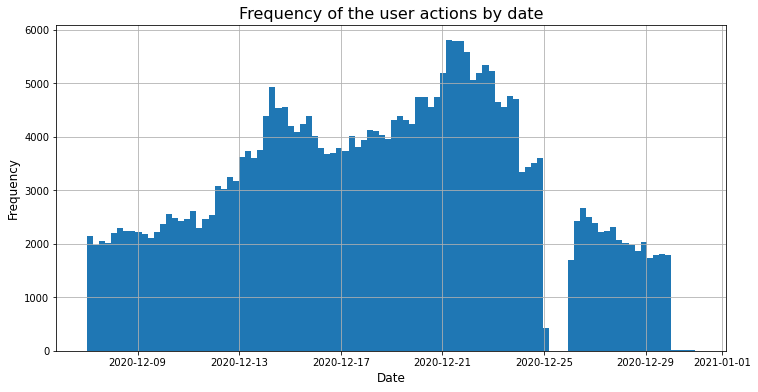

In [42]:
#plotting a histogram
plt.figure(figsize=(12,6))
df_all_users.event_dt.hist(bins=100)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency of the user actions by date', fontsize=16)
plt.show()

Histogram shows us that the number of user action is unevenly distributed by date.  
We can see number of action increasing till the Christmas eve, that's logic, people looking for presents during these dates.  
Than we can see that almost no one did any action during Christmas eve, then number of action increase a bit and sharp decrease 30 of December (probably users were too busy with preparation to the New Year party).  
Christmas&New Year Promo event that started 25 of December didn't affect to the number of orders.

[Back to the Table of Contents](#contents)

#### How many events are in the logs? <a class="anchor" id="chapter20"></a>

In [43]:
df_all_users.event_name.value_counts()

login           134643
product_page     88888
purchase         46687
product_cart     44559
Name: event_name, dtype: int64

We still have 4 events here:
- login
- product_page
- product_cart
- purchase

[Back to the Table of Contents](#contents)

#### What's the average number of events per user? <a class="anchor" id="chapter21"></a>

In [44]:
#calculating average number of action per user
avg_n_action_ab = len(df_all_users)/df_all_users.user_id.nunique()
print('Average number of events per users: {:.2f}'.format(avg_n_action_ab))

Average number of events per users: 7.25


In average each user did 7.25 actions during considered period.

[Back to the Table of Contents](#contents)

#### Checking additional informations about users <a class="anchor" id="chapter22"></a>

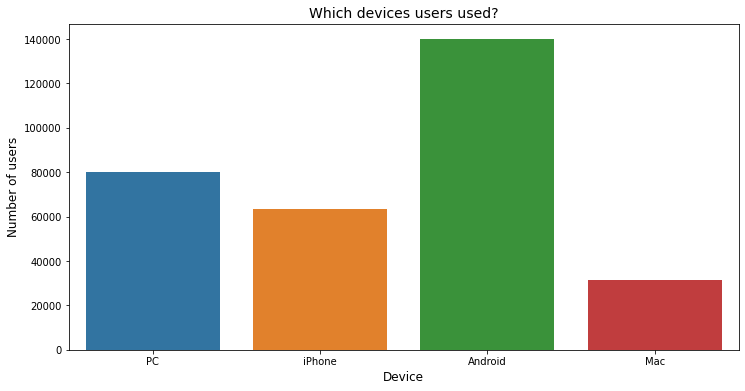

In [45]:
#studing devices
#making a graph
plt.figure(figsize=(12,6)) 
ax = sns.countplot(x='device', data=df_all_users, palette = 'tab10')
ax.set_title('Which devices users used?', fontsize=14)
ax.set_ylabel('Number of users', fontsize=12)    
ax.set_xlabel('Device', fontsize=12)
plt.show()

Most of the users use android device, then PC, iPhone and Mac.

In [46]:
#styding revenue
n_purchase = df_all_users.query('details > 0')['user_id'].count()
n_users_purchase = df_all_users.query('details > 0')['user_id'].nunique()

print('Number of purchase:', n_purchase)
print('Number of users who did purchase:', n_users_purchase)
print('Revenue: {:.2f}'.format(df_all_users.details.sum()))
print('Average revenue per user: {:.2f}'.format(df_all_users.details.sum()/n_users_purchase))

Number of purchase: 46687
Number of users who did purchase: 15155
Revenue: 1111978.13
Average revenue per user: 73.37


15155 users from EU did 46687 purchases, revenue was 1111978.13, ARPU is 73.37.

[Back to the Table of Contents](#contents)

#### Checking experimental groups <a class="anchor" id="chapter23"></a>

In [47]:
#checking experimental groups
n_events_group = df_ab_test_users.pivot_table(index='group', values='user_id', aggfunc=('count', 'nunique')).reset_index()
n_events_group.columns = ['group', 'n_events', 'n_users']
n_events_group.style.hide_index()

group,n_events,n_users
A,40078,5467
B,38851,5383


In [48]:
#checking if all users in experimental group from EU
df_ab_test_users.region.value_counts()

EU    78929
Name: region, dtype: int64

We have 2 experimental groups with:
- 40078 entries made by 5467 users in control group A;
- 38851 entries made by 5383 users in group B with new payment funnel.

[Back to the Table of Contents](#contents)

#### Conclusion <a class="anchor" id="chapter24"></a>  

Filtered data fro all EU users was stydied.  

- number of actions: 314777;
- number of users: 43396;
- average number of events per user is: 7.25;

First sign-up date: 2020-12-07  
Last sign-up date: 2020-12-23  
First action date: 2020-12-07  
Last action date: 2020-12-30  

- most of the users use android device, then PC, iPhone and Mac;
- number of purchase: 46687
- number of users who did purchase: 15155
- profit: 1111978.13
- average profit per user: 73.37.

[Back to the Table of Contents](#contents)

### 4.2 Studying the event funnel <a class="anchor" id="chapter16"></a>

#### What is the frequency of occurrence events? <a class="anchor" id="chapter25"></a>

Let's see what events are in the logs and their frequency of occurrence:

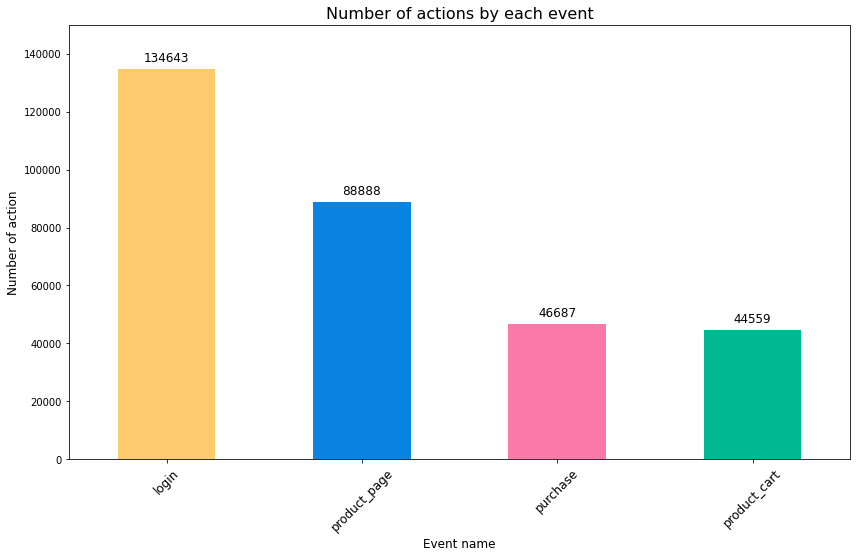

In [49]:
#plotting a graph
colors = ['#fdcb6e', '#0984e3', '#fd79a8', '#00b894', '#a29bfe']
ax = df_all_users.event_name.value_counts().plot(kind='bar', color=colors, figsize=(14,8), width=.5)
#putting text on the graph
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 11), 
                   textcoords = 'offset points', size=12)
#creating graph captions
plt.gca().set_xticklabels(df_all_users.event_name.value_counts().keys(), rotation=45, fontsize=12)
plt.xlabel('Event name', fontsize=12)
plt.ylabel('Number of action', fontsize=12)
plt.title('Number of actions by each event', fontsize=16)
plt.ylim(0, 150000)
plt.show()

The most often users login.  
Product page appear 1.5 times more rare.  
As we find on the previous step probably there is fast link for purchase, it because we have more people who bought something then visited product cart.

[Back to the Table of Contents](#contents)

#### Calculating proportion of users who performed the action at least once <a class="anchor" id="chapter26"></a>

In [50]:
#making pivot table with number of users per each event
share_users = df_all_users.pivot_table(index='event_name', values='user_id',
                                       aggfunc=lambda x: x.nunique()).sort_values('user_id',
                                                                                  ascending=False).reset_index()
share_users.columns = ['event_name', 'n_users']
#calculating the share of users who performed the action at least once
share_users['share'] = share_users['n_users']/df_all_users.user_id.nunique()
share_users.style.format({'share': "{:.2%}"}).hide_index()

event_name,n_users,share
login,43389,99.98%
product_page,28724,66.19%
purchase,15155,34.92%
product_cart,14282,32.91%


- almost 100% of users login;
- 66% of all users check the product page; 
- 35% of users did purchase; 
- 33% of users add smth to cart.

[Back to the Table of Contents](#contents)

#### What order the actions took place? <a class="anchor" id="chapter27"></a>

Let's check in what order the actions took place. Are all of them part of a single sequence? Do we need to take them into account when calculating the funnel?

In [51]:
#checking events names
df_all_users.event_name.unique()

array(['product_page', 'login', 'product_cart', 'purchase'], dtype=object)

If we analyze the sales funnel, first we need to understand which stages in particular.   
We interesting how users reached the purchase stage.  
`product_page → product_card → purchase`   
This is sequence of steps for making purchase.  
All events from log are part of the process, except 'login' stage.  
This event isn't part of one logical chain (making purchase), and could easily take place in the reverse order.

[Back to the Table of Contents](#contents)

#### First/last event for each user <a class="anchor" id="chapter28"></a>

Let's check what was the first event for each user:

In [52]:
#checking first user's event
first_act = df_all_users.sort_values('event_dt').groupby(['user_id']).agg({'event_name': 'first'}).reset_index()
first_act.columns = ['user_id', 'event_name']
first_act.event_name.value_counts()

login           29430
purchase         6664
product_page     4914
product_cart     2388
Name: event_name, dtype: int64

For most of the users first event is login (that obvious with almost 100% logged users).  
6664 users first event was purchase (there is definitely fast purchase button).  
4914 users first event was product page.  
for 2388 users - product cart.  
Let's check users last event:

In [53]:
#checking last user's event
first_act = df_all_users.sort_values('event_dt').groupby(['user_id']).agg({'event_name': 'last'}).reset_index()
first_act.columns = ['user_id', 'event_name']
first_act.event_name.value_counts()

product_page    18542
login           13804
product_cart     7924
purchase         3126
Name: event_name, dtype: int64

Looks like we lost most of users on product page event.  
13804 users did not move forward from the login event.  
And 7924 users stopped after they put product to the cart.

[Back to the Table of Contents](#contents)

#### What share of users make the entire journey from their first event to payment? <a class="anchor" id="chapter29"></a>

In [54]:
#selecting users who were in each stage
event_1_users = df_all_users.query('event_name == "product_page"').user_id
event_2_users = df_all_users.query('user_id in@event_1_users & event_name == "product_cart"').user_id
event_3_users = df_all_users.query('user_id in@event_2_users & event_name == "purchase"').user_id.nunique()
#calculating share of these users
all_events_users = event_3_users/df_all_users.user_id.nunique()
print('Share of users make the entire journey from their first event to payment: {:.2%}'.format(all_events_users))

Share of users make the entire journey from their first event to payment: 7.59%


Only 8% of all users make entire journey from their first event to payment and it far from share of users who do purchase 34.92%.  
Therefore I don't see a reason to build a funnel to find the share of users that proceed from each stage to the next.  
For comparing results of our AB test I will use a share from all users on each step. 

#### Conclusion <a class="anchor" id="chapter30"></a>  

In this step I found:  

- almost 100% of users login;
- 66% of all users check the product page;
- 35% of users did purchase;
- 33% of users add smth to cart.
  
  
- Our funnel is:  
`product_page → product_card → purchase`  
  
  
- We lost most of users on product page event.
- 7.6% of all users make the entire journey from their first event to payment.

[Back to the Table of Contents](#contents)

### 5. Evaluate the A/B test results <a class="anchor" id="chapter17"></a>

We have 15% of all users from EU in AB test groups.   
Let's study information about these users:

#### 5.1 Studying the general information of results of the experiment <a class="anchor" id="chapter31"></a>  

In [55]:
#checking experimental groups
n_events_group = df_ab_test_users.pivot_table(index='group', values='user_id', aggfunc=('count', 'nunique')).reset_index()
n_events_group.columns = ['group', 'n_events', 'n_users']
n_events_group['share'] = n_events_group['n_users']/df_ab_test_users.user_id.nunique()
#calculating share
n_events_group.style.format({'share': "{:.2%}"}).hide_index()

group,n_events,n_users,share
A,40078,5467,50.39%
B,38851,5383,49.61%


We have 2 experimental groups with:
- 40078 entries made by 5467 users in control group A, 50.4% of all participants of the AB test;
- 38851 entries made by 5383 users in group B with new payment funnel, 49.6% of all participants of the AB test.

For studying the **general information** by each group let's split data by groups:

In [56]:
#splitting data
group_A = df_ab_test_users.query('group == "A"').copy()
group_B = df_ab_test_users.query('group == "B"').copy()

Let's check if we have equally complete data for the entire period by groups:

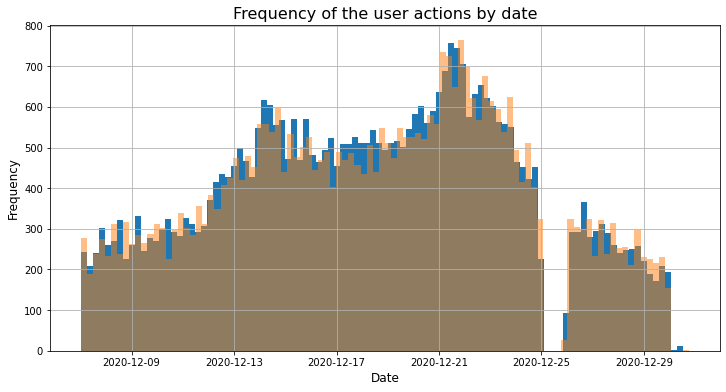

In [57]:
#plotting a histogram
plt.figure(figsize=(12,6))
group_A.event_dt.hist(bins=100)
group_B.event_dt.hist(bins=100, alpha=0.5)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency of the user actions by date', fontsize=16)
plt.show()

Histogram shows us that the number of user action is unevenly distributed by date as same as for the all users from EU region.  
Distribution look the same for A and B groups.  
We can see number of action increasing till the Christmas eve, that's logic, people looking for presents during these dates.
Than we can see that almost no one did any action during Christmas eve, then number of action increase a bit and sharp decrease 30 of December (probably users were too busy with preparation to the New Year party).
Christmas&New Year Promo event that started 25 of December didn't affect to the number of orders.

Let's find **average number of action per user by groups:**

In [58]:
#calculating average number of action per user by groups
avg_n_action_A = len(group_A)/group_A.user_id.nunique()
print('Average number of events per users in group A: {:.2f}'.format(avg_n_action_A))
avg_n_action_B = len(group_B)/group_B.user_id.nunique()
print('Average number of events per users in group B: {:.2f}'.format(avg_n_action_B))

Average number of events per users in group A: 7.33
Average number of events per users in group B: 7.22


Average number of events per users a bit less in group B, difference is 0.11.

Checking **additional informations about users by groups:**

**Devices:**

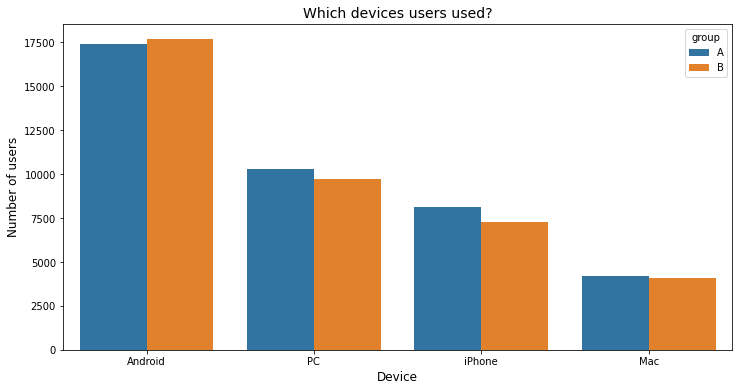

In [59]:
#making a graph
plt.figure(figsize=(12,6)) 
ax = sns.countplot(x='device', data=df_ab_test_users, hue='group', palette = 'tab10')
ax.set_title('Which devices users used?', fontsize=14)
ax.set_ylabel('Number of users', fontsize=12)    
ax.set_xlabel('Device', fontsize=12)
plt.show()

As same as all users from EU most of the users in group A and B use android device, then PC, iPhone and Mac.  
For group B we have a bit more users who used android and a bit less users with other devices than in group A.

**Revenue:**

In [60]:
#styding revenue
n_purchase_A = group_A.query('details > 0')['user_id'].count()
n_users_purchase_A = group_A.query('details > 0')['user_id'].nunique()
n_purchase_B = group_B.query('details > 0')['user_id'].count()
n_users_purchase_B = group_B.query('details > 0')['user_id'].nunique()

print('Number of purchase for group A:', n_purchase_A, ', group B:', n_purchase_B)
print('Number of users who did purchase fro group A:', n_users_purchase_A, ', group B:', n_users_purchase_B)
print('Revenue for group A: {:.2f}, group B: {:.2f}'.format(group_A.details.sum(), group_B.details.sum()))
print('Average revenue per user group A: {:.2f}, group B: {:.2f}'.format(group_A.details.sum()/n_users_purchase_A, 
                                                                        group_B.details.sum()/n_users_purchase_B ))

Number of purchase for group A: 6074 , group B: 5570
Number of users who did purchase fro group A: 1931 , group B: 1782
Revenue for group A: 145954.26, group B: 129659.30
Average revenue per user group A: 75.58, group B: 72.76


And again group A showing better result: 
- in group A we have 504 more purchase, 149 more users who did purchase;
- revenue is higher on 16294.96;
- average revenue per user also higher on 2.82.

[Back to the Table of Contents](#contents)

#### 5.2 Is there a statistically significant difference between group A and B in general? <a class="anchor" id="chapter32"></a>

Let's check whether control group are significantly different from the test group or not.  
To do this, we need to use the test of proportions or z-score:

In [61]:
#saving number of users for each groups in the parameters
successes_A = n_events_group['n_users'].iloc[0]
successes_B = n_events_group['n_users'].iloc[1]
#checking result
print(successes_A, successes_B)

5467 5383


In [62]:
#calculating trails
trails = df_ab_test_users['user_id'].nunique()
#checking result
trails

10850

Now we have parameters with number of users from control and test groups and we will use it in hypothesis testing.  
Let's formulate hypotheses:

H0 - proportions of the group A and group B are equal (H0 is always stated with an equal sign);  
H1 - proportions of the group A and group B are not equal.

What do we know about significance level in statistic tests?  
One of the criteria for a successful A/B test is: None of the key metrics varies by a statistically significant amount—typically by no more than 5%.   
The alpha level we set relates to the confidence level:  
- 0.05 - 95% confidence level  
- 0.01 - 99% confidence level   

The extent to which the key metrics differ among groups depends on how sensitive the experiments needs to be. 5% precision for A/B testing is a common criterion.  
Therefore I will take 0.05 alpha level for all A/B tests:

In [63]:
#testing hypothesis
alpha = .05 # significance level

successes1 = successes_A
successes2 = successes_B
trials = trails

#success proportion in the 246 group:
p1 = successes1/trials
#success proportion in the 247 group:
p2 = successes2/trials
#success proportion in the combined dataset:
p_combined = (successes1 + successes2) / (trials + trials)
#the difference between the datasets' proportions
difference = p1 - p2
#calculating the statistic in standard deviations of the standard normal distribution
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials + 1/trials))
#setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1)

p_value_AA = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value_AA)

if (p_value_AA < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the proportions")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the proportions are different")

p-value:  0.25409541110640776
Failed to reject the null hypothesis: there is no reason to consider the proportions are different


Result of the test shows us that there is no reason to consider the proportions are different.

[Back to the Table of Contents](#contents)

#### 5.3 Studying the events in the groups <a class="anchor" id="chapter33"></a>

Let's see what events are in the logs and their frequency of occurrence for each group:

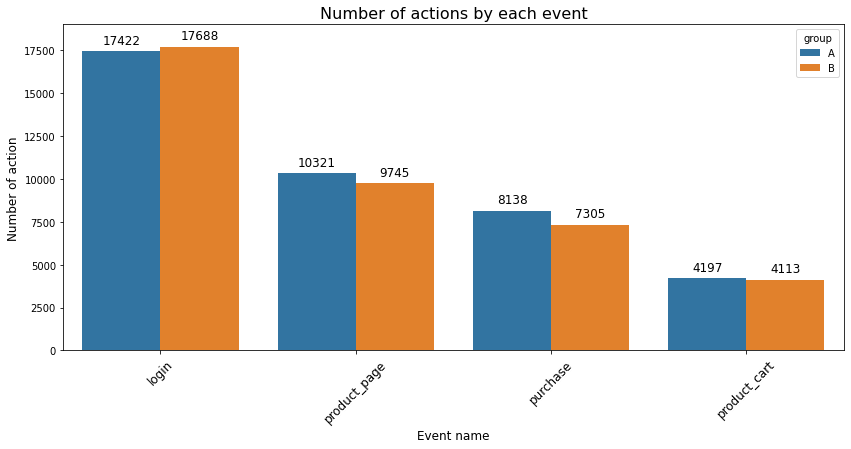

In [64]:
#plotting a graph
plt.figure(figsize=(14,6)) 
ax = sns.countplot(x='device', data=df_ab_test_users, hue='group', palette = 'tab10')
#putting text on the graph
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 11), 
                   textcoords = 'offset points', size=12)
#creating graph captions
plt.gca().set_xticklabels(df_ab_test_users.event_name.value_counts().keys(), rotation=45, fontsize=12)
plt.xlabel('Event name', fontsize=12)
plt.ylabel('Number of action', fontsize=12)
plt.title('Number of actions by each event', fontsize=16)
plt.ylim(0, 19000)
plt.show()

Graph looks the same as for all users from EU.  
We have a bit more users from group B in login event and a bit less in the other events than users from group A.

Let's find conversion in events for each group:

In [65]:
#calculating number of users in each group by event
pivot = df_ab_test_users.query('event_name != "login"').pivot_table(index='event_name', values='user_id',
                                                                    columns='group',
                                                                    aggfunc=lambda x: x.nunique()).reset_index()
pivot.columns = ['event_name', 'A', 'B']
ab_u_event = pivot.copy()
#calculating a share
ab_u_event['share_A']= ab_u_event['A']/successes_A
ab_u_event['share_B']= ab_u_event['B']/successes_B
#checking result
ab_u_event.sort_values('A', ascending=False).style.format({'share_A': "{:.2%}",
                                                                 'share_B': "{:.2%}"}).hide_index()

event_name,A,B,share_A,share_B
product_page,3639,3527,66.56%,65.52%
purchase,1931,1782,35.32%,33.10%
product_cart,1756,1812,32.12%,33.66%


In [67]:
pivot[pivot['event_name'] == 'product_page']['A'].iloc[0]

3639

In group B we have less users in `product page` and `purchase` events, conversion are less for each event than for users from A group.

[Back to the Table of Contents](#contents)

#### 5.4 Is there a statistically significant difference between group A and B in events? <a class="anchor" id="chapter34"></a>

 We need to check whether two control and test groups are significantly different in each event.  
 To do that I will use the test of proportions or z-score again, but for each event:

Now, in our case value of successes will be number of users for each group per event from pivot table.  
Value of the trials - the number of users in the groups.  
Let's formulate hypotheses:

H0 - share of users that had "name of event" event of the group A is equal to the group B;  
H1 - share of users that had "name of event" event of the group A is not equal to the group B.

In [68]:
#creating function for checking hypothesis
def test_hypothesis(group1, group2, event, alpha):
    
    #getting variables for the test:
    #accessing to value of success directly from pivot table
    successes1=pivot[pivot['event_name']==event][group1].iloc[0]
    successes2=pivot[pivot['event_name']==event][group2].iloc[0]
    
    #accessing to value of trials from df_new
    trials1=df_ab_test_users[df_ab_test_users['group']==group1]['user_id'].nunique()
    trials2=df_ab_test_users[df_ab_test_users['group']==group2]['user_id'].nunique()

    #proportion for success in the first group
    p1 = successes1/trials1
    #proportion for success in the second group
    p2 = successes2/trials2
    #proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    #the difference between the datasets' proportions
    difference = p1 - p2
    #calculating the statistic in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    #setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Reject H0 for", event,'event and groups:',
              group1,'and', group2, 'there is a significant difference between the proportions')
    else:
        print("Fail to Reject H0 for", event,'event and groups:',
              group1,'and', group2, ', there is no reason to consider the proportions are different')  

In [69]:
#applying the function for all events
for i in pivot.event_name.unique():
    test_hypothesis('A', 'B', i, alpha=0.05)

p-value:  0.08746918913258162
Fail to Reject H0 for product_cart event and groups: A and B , there is no reason to consider the proportions are different
p-value:  0.2518419682737163
Fail to Reject H0 for product_page event and groups: A and B , there is no reason to consider the proportions are different
p-value:  0.014959088807690257
Reject H0 for purchase event and groups: A and B there is a significant difference between the proportions


Result of the tests show us that there is no reason to consider the proportions are different for each events, exept purchase event.  
So, looks like there is no difference between control and test groups in general, but there is differnense in purchase event.  
Experiment shows us that users react different to the improved recommendation system.

[Back to the Table of Contents](#contents)

#### Conclusion <a class="anchor" id="chapter35"></a>

In this step I found:
- 40078 entries made by 5467 users in control group A, 50.4% of all participants of the AB test;
- 38851 entries made by 5383 users in group B with new payment funnel, 49.6% of all participants of the AB test.

First sign-up date: 2020-12-07   
Last sign-up date: 2020-12-23   
First action date: 2020-12-07   
Last action date: 2020-12-30   

Most of the users use android device, then PC, iPhone and Mac in both groups.

Number of purchase: 
- group A: 6074
- group B: 5570

Number of users who did purchase: 
- group A: 1931
- group B: 1782

Revenue:  
- group A: 145954.26
- group B: 129659.30

Average revenue per user:
- group A: 75.58
- group B: 72.76

Average number of events per users in group A: 7.33
Average number of events per users in group B: 7.22

Group A:
- 66.56% of all users check the product page;
- 35.32% of users did purchase;
- 32.12% of users add smth to cart.

Group B:
- 65.52% of all users check the product page;
- 33.10% of users did purchase;
- 33.66% of users add smth to cart.

There is no significant difference between control (A) and test (B) groups in general, but there is differnense in purchase event.

[Back to the Table of Contents](#contents)

### Overall conclusion <a class="anchor" id="chapter36"></a>

Number of events is: 78929   
Group A: 40078  
Group B: 38851  
Number of unique users is: 10850  
Group A: 5467  
Group B: 5383  
Considered period:   
Sign-up: 2020-12-07 - 2020-12-23  
Action: 2020-12-07 - 2020-12-30  

---

- 7.6% of all users make the entire journey from their first event to payment.
- most of users we lose on product page event.

---

Funnel:  
`product_page → product_card → purchase` 

Group A:
- 66.56% of all users check the product page;
- 35.32% of users did purchase;
- 32.12% of users add smth to cart.

Group B:
- 65.52% of all users check the product page;
- 33.10% of users did purchase;
- 33.66% of users add smth to cart.

Average number of events per users in group A: 7.33
Average number of events per users in group B: 7.22

---

Number of purchase: 
- group A: 6074
- group B: 5570

Number of users who did purchase: 
- group A: 1931
- group B: 1782

Revenue:  
- group A: 145954.26
- group B: 129659.30

Average revenue per user:
- group A: 75.58
- group B: 72.76

---
Result of tests show that:

- There is no significant difference between control (A) and test (B) groups in general, but there is differnense in `purchase` event.

Looks like users react different to the improved recommendation system.  

Probably that changing will alienate some users to do purchase (cause we see decreasing in number of purchase for B group and statistical difference in proportions between control and test group).   

Since we didn't get increasing in conversion in every steps in test group and there is no statistical difference between groups in general and events product page and cart, I assume that new recommendation system will not prompt more users to move to the next stages. 

[Back to the Table of Contents](#contents)